# Keras 창시자에게 배우는 딥러닝

## 데이터 내려받기 테스트
- 캐글 이미지 데이터를 구글 코랩으로 불러오기
- (API) 통해서 불러오기

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"foodgoon","key":"51cf808f8fdfe72a9ddcee186051dea4"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c titanic

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 44.0MB/s]


In [4]:
!unzip titanic.zip

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


- p.282 합성곱 신경망 소개

## 간단한 합성곱 만들기
- 합성곱 층과 MaxPooling 층을 연달아서 쌓아 올림

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(28, 28, 1)) # 입력층 만듬, Input < i 대문자

# 합성곱 층, filters = 깊이
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs) # 함수형 API
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)

# 출력층
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856 

## MNIST 이미지 합성곱 훈련
- 2장의 연결 네트워크는 97.8%

In [7]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/5
938/938 [==============================] - 15s 5ms/step - loss: 0.1629 - accuracy: 0.9495
Epoch 2/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0463 - accuracy: 0.9857
Epoch 3/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0315 - accuracy: 0.9906
Epoch 4/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0236 - accuracy: 0.9931
Epoch 5/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0181 - accuracy: 0.9942


In [8]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.0238 - accuracy: 0.9932
0.9932000041007996


## p.292
- 최대 폴링 층이 빠진 잘못된 구조의 합성곱
  + 가장 큰 문제점 : 이미지 압축이 안됨

In [9]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_no_max_pool = keras.Model(inputs=inputs, outputs=outputs)

In [10]:
model_no_max_pool.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 128)       73856     
                                                                 
 flatten_1 (Flatten)         (None, 61952)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                619530    
                                                                 
Total params: 712,202
Trainable params: 712,202
Non-trainab

## 개와 고양이 이미지 다운로드

In [11]:
!kaggle competitions download -c dogs-vs-cats

 98% 799M/812M [00:04<00:00, 240MB/s]
100% 812M/812M [00:04<00:00, 180MB/s]


In [12]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

In [13]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

## 모델 만들기

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3)) # 180x180 크기의 RGB 이미지를 기대함.
x = layers.Rescaling(1./255)(inputs) # 입력을 255로 나누어 [0, 1] 범위의 스케일 조정
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [15]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                       

In [16]:
model.compile(loss ="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

## 데이터 전처리
- p. 301

In [17]:
from tensorflow.keras.utils import image_dataset_from_directory

new_base_dir = pathlib.Path("cats_vs_dogs_small")

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size = (180, 180),
    batch_size = 32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size = (180, 180),
    batch_size = 32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size = (180, 180),
    batch_size = 32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### 텐서플로 Dataset 객체 이해하기
- 샘플 데이터 1000개 만들기

In [18]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

- 하나의 샘플 확인하기

In [19]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


- 데이터 배치

In [20]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


- 원소 크기를 (16, 0) -> (4, 4)

In [21]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


### Dataset이 반환하는 데이터 및 레이블 크기 확인

In [22]:
for data_batch, labels_batch in train_dataset:
  print("데이터 배치 크기", data_batch.shape)
  print("레이블 배치 크기", labels_batch.shape)
  break

데이터 배치 크기 (32, 180, 180, 3)
레이블 배치 크기 (32,)


### 모델 훈련하기

In [24]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True, # 1epoch vs 2epoch
        monitor="val_loss")  #
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data = validation_dataset,
    callbacks = callbacks)

Epoch 1/30
63/63 [==============================] - 14s 149ms/step - loss: 0.6950 - accuracy: 0.5075 - val_loss: 0.6910 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 5s 70ms/step - loss: 0.6978 - accuracy: 0.5285 - val_loss: 0.6903 - val_accuracy: 0.5070
Epoch 3/30
63/63 [==============================] - 6s 88ms/step - loss: 0.6787 - accuracy: 0.5765 - val_loss: 0.6840 - val_accuracy: 0.5360
Epoch 4/30
63/63 [==============================] - 5s 69ms/step - loss: 0.6429 - accuracy: 0.6305 - val_loss: 0.7523 - val_accuracy: 0.5550
Epoch 5/30
63/63 [==============================] - 6s 90ms/step - loss: 0.6036 - accuracy: 0.6690 - val_loss: 0.6292 - val_accuracy: 0.6560
Epoch 6/30
63/63 [==============================] - 5s 69ms/step - loss: 0.5555 - accuracy: 0.7075 - val_loss: 0.6132 - val_accuracy: 0.6950
Epoch 7/30
63/63 [==============================] - 5s 68ms/step - loss: 0.5427 - accuracy: 0.7360 - val_loss: 0.6602 - val_accuracy: 0.6930
Epoch 8/30


In [25]:
import matplotlib.pyplot as plt
def check_train_val_plot(history):
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  epochs = range(1, len(accuracy) + 1)
  fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
  ax[0].plot(epochs, accuracy, "bo", label="Training accuracy")
  ax[0].plot(epochs, val_accuracy, "b", label="Validation accuracy")
  ax[0].set_title("Training and validation accuracy")
  ax[0].legend()
  ax[1].plot(epochs, loss, "bo", label="Training loss")
  ax[1].plot(epochs, val_loss, "b", label="Validation loss")
  ax[1].set_title("Training and validation loss")
  ax[1].legend()
  plt.show()

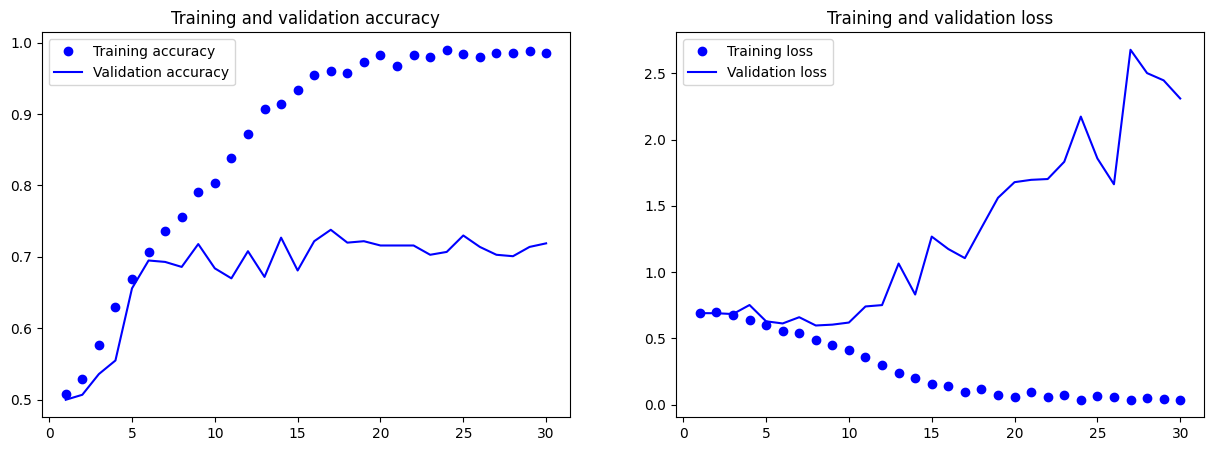

In [26]:
check_train_val_plot(history)

### 테스트 모델에서 모델평가

In [29]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

63/63 [==============================] - 4s 45ms/step - loss: 0.6104 - accuracy: 0.6970
테스트 정확도: 0.697


### 데이터 증식 사용
- https://opencv.org/
- https://albumentations.ai/

In [36]:
data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ])

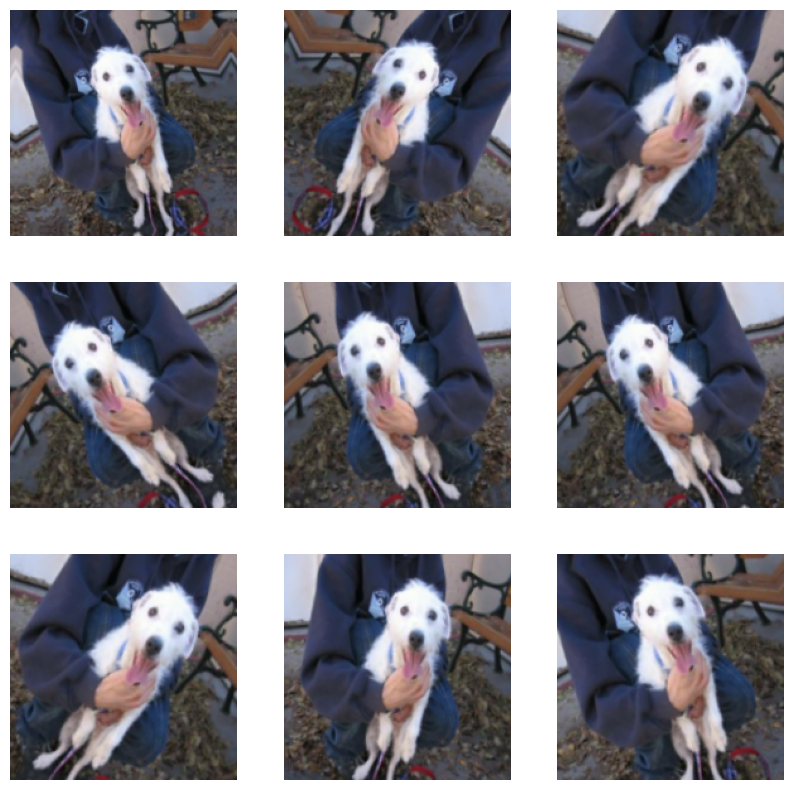

In [37]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [38]:
inputs = keras.Input(shape=(180, 180, 3)) # 입력층
x = data_augmentation(inputs)             # 데이터 증식 단계 통과 시킴
x = layers.Rescaling(1./255)(x)           # 이미지 [0, 1]

# 은닉층
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)                # 드롭아웃을 적용하면 과대적합이 덜 일어난다.

# 출력층
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [39]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True, # 1epoch vs 2epoch
        monitor="val_loss")  #
]

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data = validation_dataset,
    callbacks = callbacks)

### 테스트 세트에서 모델 정확도 확인

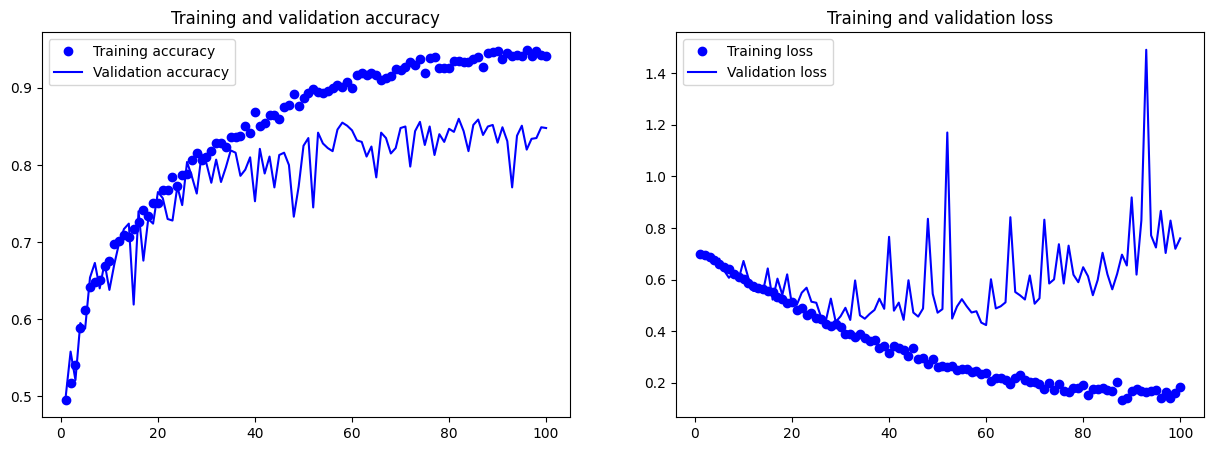

In [41]:
check_train_val_plot(history)

In [42]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras") # 저장된 모델 불러오기
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

63/63 [==============================] - 3s 36ms/step - loss: 0.4282 - accuracy: 0.8380
테스트 정확도: 0.838


## 사전 훈련됨 모델
- 일반 정확도 68.8%
- 데이터 증식 정확도 : 83.8%
- 사전 훈련된 모델 : 97.5%
- 모델 미세 조정하기 : 98.5
- 결론 : 딥러닝 프로젝트,
  + 주요 키워드 --> 사전 훈련된 모델 & 모델 미세 조정하기
  + Chat GPT 샘플 코드 요청

## 머신러닝 프로젝트 vs 딥러닝 프로젝트
- 머신러닝 프로젝트의 핵심은 정확도 + 변수 추출 과정 설명 중요
  + 데이터분석가 지망생들이 많이 함
- 딥러닝 프로젝트의 핵심은 정확도 + 어떤 모델 썼느냐 ! 모델에 대한 설명(영어 논문 또는 한글로 번역한 유튜브 공부!)
  + 컴공 출신들이 많이 함

## 사전 훈련된 모델 활용 p.321
- pretrained model
- https://paperswithcode.com/paper/very-deep-convolutional-networks-for-large
- https://arxiv.org/pdf/1905.11946.pdf